In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
tweets = df[['id', 'text', 'target']]
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [6]:
tweets.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

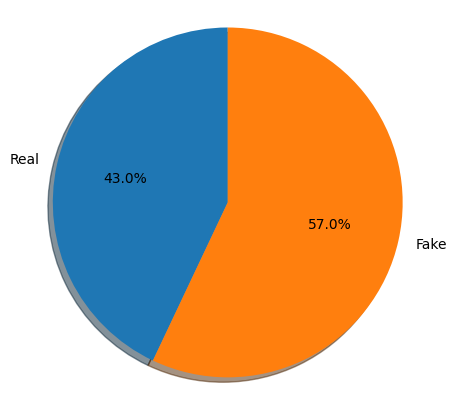

In [10]:
fig = plt.figure(figsize=(5, 5))

labels = 'Real', 'Fake'

sizes = [len(tweets.loc[tweets['target'] == 1]), len(tweets.loc[tweets['target'] == 0])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [19]:
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import PorterStemmer
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/vuhan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
def process_tweets(tweet, stem=True):
    
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    stopwords_eng = stopwords.words('english')
    tweet_clean = []
    for word in tweet_tokens:
        if word not in stopwords_eng and word not in string.punctuation:
            tweet_clean.append(word)
    if stem==False:
        return tweet_clean
    else:    
        tweet_stem = []
        stemmer = PorterStemmer()
        for word in tweet_clean:
            stem_word = stemmer.stem(word)
            tweet_stem.append(stem_word)
        return tweet_stem

In [34]:
org_tweet = tweets.iloc[0, 1]
print('Tweet: {}'.format(org_tweet))
print()
token_tweet = process_tweets(org_tweet)
print('Tokenized Tweet: {}'.format(token_tweet))

Tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Tokenized Tweet: ['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']


In [31]:
np.squeeze(tweets['target'].values)

array([1, 1, 1, ..., 1, 1, 1])

In [40]:
def build_freqs(label, tweets):
    y_list = np.squeeze(label).tolist()
    
    freqs = {}
    
    for y, tweet in zip(y_list, tweets):
        for word in process_tweets(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [41]:
tweet = tweets['text']
label = tweets['target']

freqs = build_freqs(label, tweet)

In [43]:
len(freqs)

15929

In [44]:
def word_count_table(sample):
    keys = process_tweets(sample)
    
    data = []
    for word in keys:
        real = 0
        fake = 0
        
        if (word, 1) in freqs:
            real = freqs.get((word, 1), 0)
        if (word, 0) in freqs:
            fake = freqs.get((word, 0), 0)
        data.append([word, real, fake])
    return data

In [46]:
word_count_table(tweet[0])

[['deed', 1, 1],
 ['reason', 8, 23],
 ['earthquak', 47, 6],
 ['may', 50, 38],
 ['allah', 6, 3],
 ['forgiv', 1, 2],
 ['us', 49, 75]]

In [57]:
demo = 'happi merri nice good bad sad mad best pretti ❤ :) :( 😒 😬 😄 😍 ♛ song idea power play magnific'
demo1 = tweet[0]
tmp = word_count_table(demo1)
tmp

[['deed', 1, 1],
 ['reason', 8, 23],
 ['earthquak', 47, 6],
 ['may', 50, 38],
 ['allah', 6, 3],
 ['forgiv', 1, 2],
 ['us', 49, 75]]

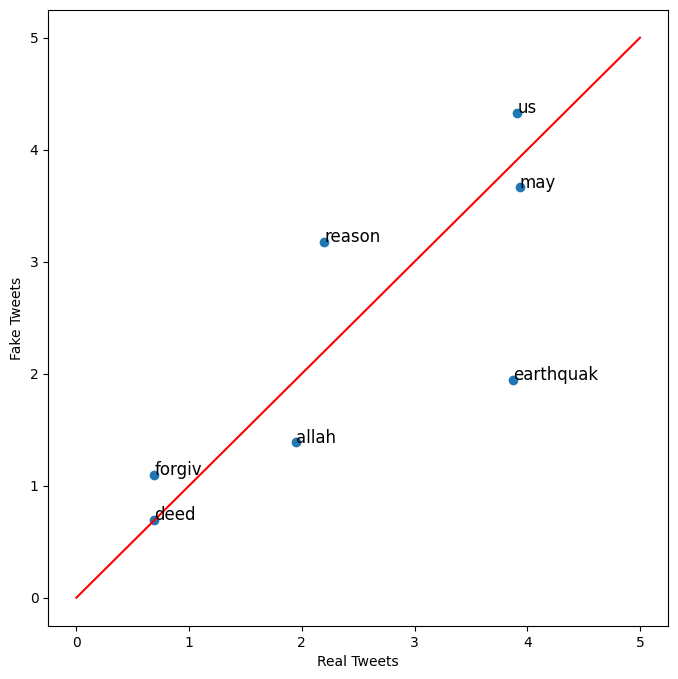

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))

x = np.log([x[1] + 1 for x in tmp])
y = np.log([x[2] + 1 for x in tmp])

ax.scatter(x, y)

plt.xlabel('Real Tweets')
plt.ylabel('Fake Tweets')

ax.plot([0, 5], [0, 5], color='r')

for i in range(0, len(tmp)):
    ax.annotate(tmp[i][0], (x[i], y[i]), fontsize=12);

In [61]:
data = pd.DataFrame(tmp, columns=['word', 'pos', 'neg'])
data['bias'] = [1] * len(data)
data

,word,pos,neg,bias
0,deed,1,1,1
1,reason,8,23,1
2,earthquak,47,6,1
3,may,50,38,1
4,allah,6,3,1
5,forgiv,1,2,1
6,us,49,75,1


In [62]:
np.zeros(3)

array([0., 0., 0.])

In [63]:
def extract_features(tweet):
    word_l = process_tweets(tweet)
    x = np.zeros(3)
    x[0] = 1
    for word in word_l:
        x[1] += freqs.get((word, 1), 0)
        x[2] += freqs.get((word, 0), 0)
        
    x = x[np.newaxis, :]
    return x

In [65]:
tmp1 = extract_features(demo1)
tmp1

array([[  1., 162., 148.]])

In [72]:
X_train = np.zeros((len(tweets), 3))

for i in range(len(tweet)):
    X_train[i, :] = extract_features(tweet[i])

In [73]:
X_train

array([[  1., 162., 148.],
       [  1., 402., 120.],
       [  1., 253., 125.],
       ...,
       [  1.,  83.,   9.],
       [  1., 358., 226.],
       [  1., 599., 120.]])

In [74]:
y_train = label.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [75]:
def sigmoid(z):
    h = 1 / (1 + np.exp(-z))
    return h

<a name='ex-2'></a>
## Gradient Descent
Implement gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [76]:
def gradient_descent(x, y, theta, alpha, num_iter):
    m = x.shape[0]
    for i in range(0, num_iter):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = (-1 / m) * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h)))
        theta = theta - (alpha / m) * np.dot(x.T, (h-y))
    J = float(J)
    return J, theta

## Training Model

In [78]:
J, theta = gradient_descent(X_train, y_train, np.zeros((3, 1)), 1e-9, 1500)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
J = (-1 / m) * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h)))